CS4001/4042 Assignment 1, Part B, Q3
---

Besides ensuring that your neural network performs well, it is important to be able to explain the model’s decision. **Captum** is a very handy library that helps you to do so for PyTorch models.

Many model explainability algorithms for deep learning models are available in Captum. These algorithms are often used to generate an attribution score for each feature. Features with larger scores are more ‘important’ and some algorithms also provide information about directionality (i.e. a feature with very negative attribution scores means the larger the value of that feature, the lower the value of the output).

In general, these algorithms can be grouped into two paradigms:
- **perturbation based approaches** (e.g. Feature Ablation)
- **gradient / backpropagation based approaches** (e.g. Saliency)

The former adopts a brute-force approach of removing / permuting features one by one and does not scale up well. The latter depends on gradients and they can be computed relatively quickly. But unlike how backpropagation computes gradients with respect to weights, gradients here are computed **with respect to the input**. This gives us a sense of how much a change in the input affects the model’s outputs.





---



---



In [1]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.2 MB/s eta 0:00:00


In [2]:
SEED = 42

import os

import random
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import pandas as pd

import torch
import torch.nn as nn

from captum.attr import Saliency, InputXGradient, IntegratedGradients, GradientShap, FeatureAblation

> First, load the dataset following the splits in Question B1. To keep things simple, we will **limit our analysis to numeric / continuous features only**. Drop all categorical features from the dataframes. Do not standardise the numerical features for now.



In [3]:
# TODO: Enter your code here
df = pd.read_csv('hdb_price_prediction.csv')

df_dropped = df.drop(["month", "town", "full_address", "nearest_stn", "flat_model_type", "storey_range"], axis=1)

train_df = df_dropped[df_dropped["year"] <= 2019].drop("year", axis=1)
y_train = train_df["resale_price"]
X_train = train_df.drop("resale_price", axis=1)


val_df = df_dropped[df_dropped["year"] == 2020].drop("year", axis=1)
y_val = val_df["resale_price"]
X_val = val_df.drop("resale_price", axis=1)


test_df = df_dropped[df_dropped["year"] == 2021].drop("year", axis=1)
y_test = test_df["resale_price"]
X_test = test_df.drop("resale_price", axis=1)


> Follow this tutorial to generate the plot from various model explainability algorithms (https://captum.ai/tutorials/House_Prices_Regression_Interpret).
Specifically, make the following changes:
- Use a feedforward neural network with 3 hidden layers, each having 5 neurons. Train using Adam optimiser with learning rate of 0.001.
- Use Saliency, Input x Gradients, Integrated Gradients, GradientSHAP, Feature Ablation


In [4]:
# TODO: Enter your code here


#NO SCALING

#designing FFN
class FFN(nn.Module):
    def __init__(self, no_features, no_output):
        super().__init__()
        self.ffn_stack = nn.Sequential(
            # YOUR CODE HERE
            nn.Linear(no_features, 5),  #first hidden layer
            nn.ReLU(),

            nn.Linear(5, 5),  #second hidden layer
            nn.ReLU(),

            nn.Linear(5, 5),  #third hidden layer
            nn.ReLU(),

            nn.Linear(5, no_output),  #output layer
        )

    # YOUR CODE HERE
    def forward(self, x):
        logits = self.ffn_stack(x)
        return logits

#implementing train loop
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()  #initialize gradient calculations
        loss.backward()  #compute gradients
        optimizer.step()  #take one step of SGD

        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    train_loss /= size
    correct /= size
    return train_loss, correct


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size

    return test_loss, correct


# early stopping obtained from tutorial
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False



lr = 0.001
no_features = 6
no_output = 1
batch_size = 1024
no_epochs = 200

#defining our model, optimizer, loss
model = FFN(no_features, no_output)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = torch.nn.MSELoss()


#preparing our data
X_train_tensor = torch.tensor(X_train.values).float()
y_train_tensor = torch.tensor(y_train.values).view(-1, 1).float()

X_val_tensor = torch.tensor(X_val.values).float()
y_val_tensor = torch.tensor(y_val.values).view(-1, 1).float()

X_test_tensor = torch.tensor(X_test.values).float()
y_test_tensor = torch.tensor(y_test.values).view(-1, 1).float()

#train dataloader
train_data = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

#val dataloader
val_data = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)

#test dataloader
test_data = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

#initialising early stopper
early_stopper = EarlyStopper(min_delta = 100000)
early_stopper_bool = False


#training the model
train_loss_, val_loss_ = [], []
for epoch in range(no_epochs):
    train_loss, train_acc = train_loop(train_dataloader, model, loss_fn, optimizer)
    val_loss, val_accuracy = test_loop(val_dataloader, model, loss_fn)

    if epoch%20 == 19:
      print(f"Epoch {epoch+1}, train_loss {train_loss:>7f}, val_loss {val_loss:>7f}")
      print("Done!")

    #early stopping on validation loss
    early_stopper_bool = early_stopper.early_stop(val_loss)
    if early_stopper_bool:
        print(f"Early stopped at {epoch+1}!")
        break

Epoch 20, train_loss 72476199.045225, val_loss 70650729.121091
Done!
Epoch 40, train_loss 15348955.084878, val_loss 14772430.706301
Done!
Epoch 60, train_loss 14704319.613344, val_loss 14217583.951272
Done!
Epoch 80, train_loss 13931354.994958, val_loss 13503344.676018
Done!
Epoch 100, train_loss 13071090.432084, val_loss 12756866.640930
Done!
Epoch 120, train_loss 12144009.601449, val_loss 12012904.484193
Done!
Epoch 140, train_loss 11074884.526968, val_loss 11131826.122764
Done!
Epoch 160, train_loss 9472676.093854, val_loss 9809228.790117
Done!
Epoch 180, train_loss 7015133.762493, val_loss 7601323.237679
Done!
Epoch 200, train_loss 5622116.706308, val_loss 6322570.503324
Done!


In [5]:
from sklearn.metrics import mean_squared_error

pred = model(X_test_tensor)
rmse = np.sqrt(mean_squared_error(y_test_tensor.detach().numpy(), pred.detach().numpy()))
print("RMSE: ", rmse)

RMSE:  104648.28


In [6]:
#i will be using the first 1000 samples (specified by SCSE Chan Yi Hao in the dicussion board)

first_1000_X_test_tensor = X_test_tensor[0:1000]

sl = Saliency(model)
inpg = InputXGradient(model)
intg = IntegratedGradients(model)
gs = GradientShap(model)
fa = FeatureAblation(model)

sl_attr_test = sl.attribute(first_1000_X_test_tensor)
inpg_attr_test = inpg.attribute(first_1000_X_test_tensor)
intg_attr_test = intg.attribute(first_1000_X_test_tensor)
gs_attr_test = gs.attribute(first_1000_X_test_tensor, X_train_tensor)
fa_attr_test = fa.attribute(first_1000_X_test_tensor)

/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


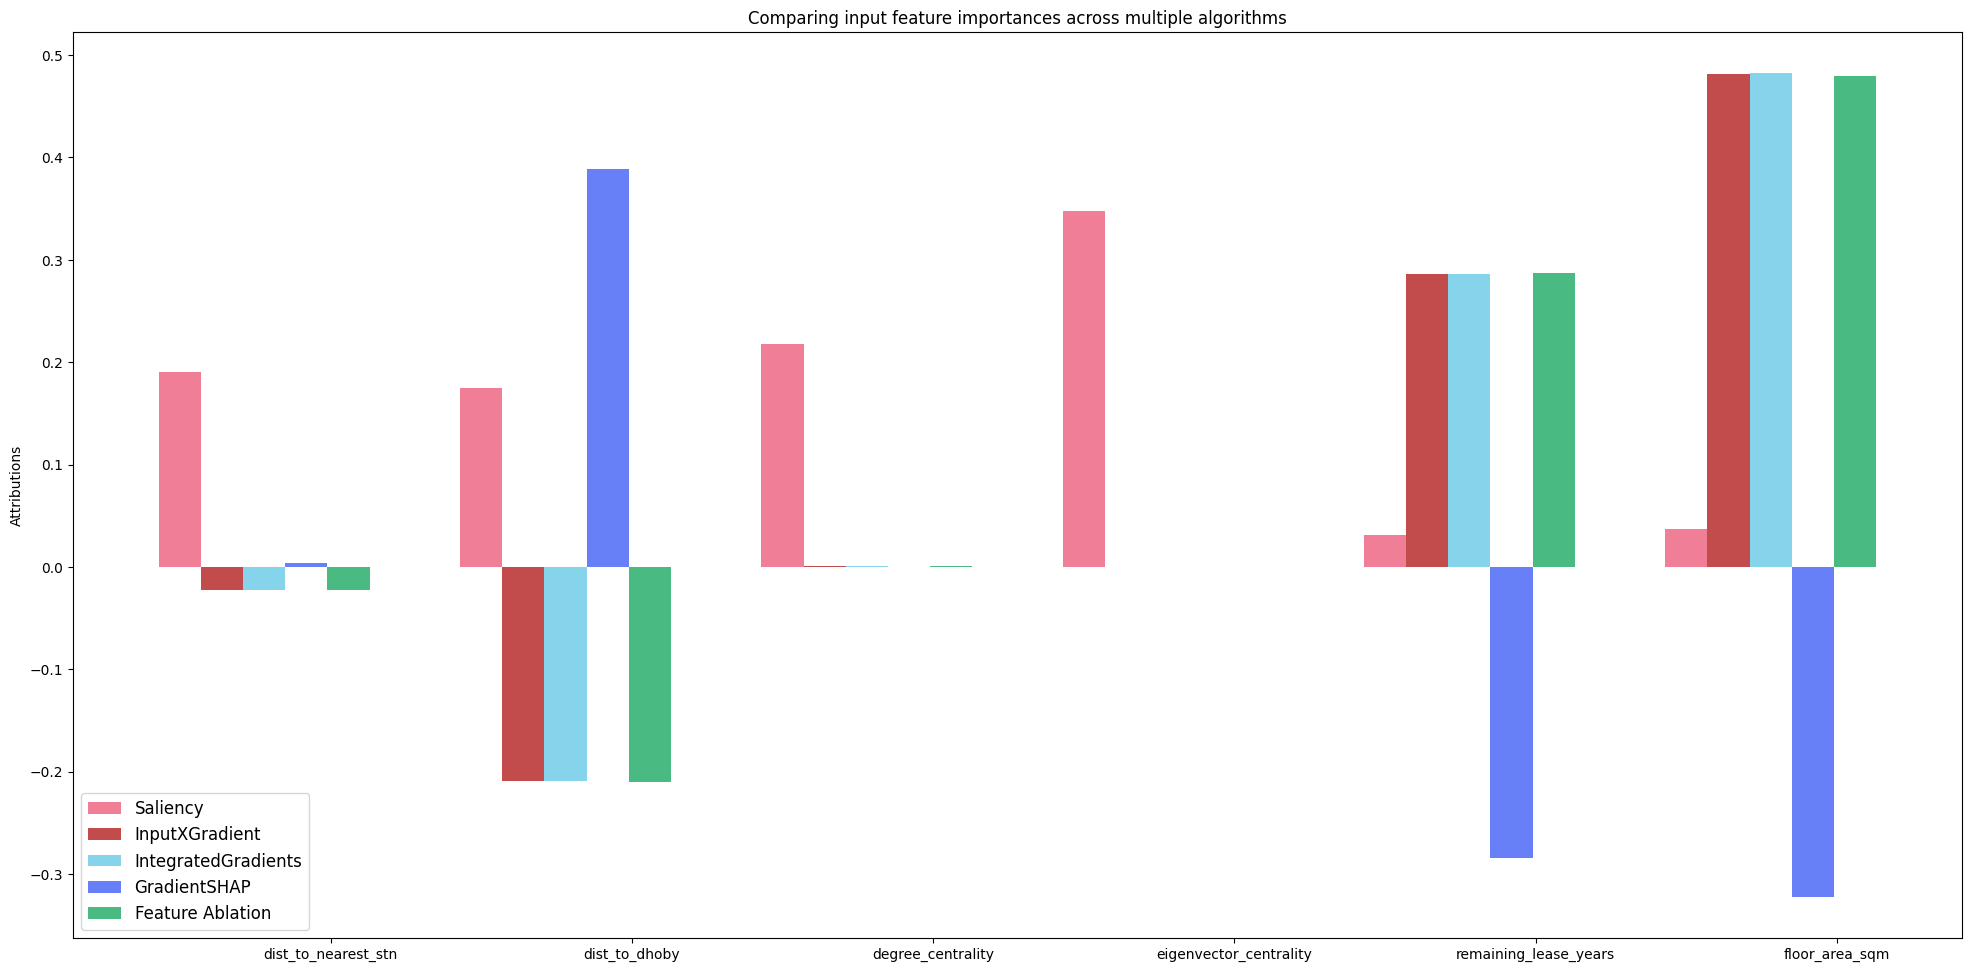

In [7]:
import matplotlib.pyplot as plt

#prepare attributions for visualization
x_axis_data = np.arange(X_test_tensor.shape[1])

#Saliency
sl_attr_test_sum = sl_attr_test.detach().numpy().sum(0)
sl_attr_test_norm_sum = sl_attr_test_sum / np.linalg.norm(sl_attr_test_sum, ord=1)

#InputXGradient
inpg_attr_test_sum = inpg_attr_test.detach().numpy().sum(0)
inpg_attr_test_norm_sum = inpg_attr_test_sum / np.linalg.norm(inpg_attr_test_sum, ord=1)

#IntegratedGradients
intg_attr_test_sum = intg_attr_test.detach().numpy().sum(0)
intg_attr_test_norm_sum = intg_attr_test_sum / np.linalg.norm(intg_attr_test_sum, ord=1)

#GradientShap
gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

#FeatureAblation
fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)

width = 0.14
legends = ['Saliency', 'InputXGradient','IntegratedGradients', 'GradientSHAP', 'Feature Ablation']

plt.figure(figsize=(20, 10))

ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data, sl_attr_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
ax.bar(x_axis_data + width, inpg_attr_test_norm_sum, width, align='center', alpha=0.7, color='#A90000')
ax.bar(x_axis_data + 2 * width, intg_attr_test_norm_sum, width, align='center', alpha=0.6, color='#34b8e0')
ax.bar(x_axis_data + 3 * width, gs_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
ax.bar(x_axis_data + 4 * width, fa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')

ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(["dist_to_nearest_stn",	"dist_to_dhoby", "degree_centrality",	"eigenvector_centrality",	"remaining_lease_years", "floor_area_sqm"])

plt.legend(legends, loc=3)
plt.show()

> Train a separate model with the same configuration but now standardise the features via **StandardScaler** (fit to training set, then transform all). State your observations with respect to GradientShap and explain why it has occurred.
(Hint: Many gradient-based approaches depend on a baseline, which is an important choice to be made. Check the default baseline settings carefully.)


In [8]:
# TODO: Enter your code here

#WITH SCALING
from sklearn.preprocessing import StandardScaler


#Scaling our inputs
standard_scaler = StandardScaler()
X_train_scaled = standard_scaler.fit_transform(X_train)
X_val_scaled = standard_scaler.transform(X_val)
X_test_scaled = standard_scaler.transform(X_test)


#defining our second model
model2 = FFN(no_features, no_output)
optimizer = torch.optim.Adam(model2.parameters(), lr=lr)
loss_fn = torch.nn.MSELoss()


#preparing our data
X_train_scaled_tensor = torch.tensor(X_train_scaled).float()
y_train_tensor = torch.tensor(y_train.values).view(-1, 1).float()

X_val_scaled_tensor = torch.tensor(X_val_scaled).float()
y_val_tensor = torch.tensor(y_val.values).view(-1, 1).float()

X_test_scaled_tensor = torch.tensor(X_test_scaled).float()
y_test_tensor = torch.tensor(y_test.values).view(-1, 1).float()

#first 1000 to be used later
first_1000_X_test_scaled_tensor = X_test_scaled_tensor[0:1000]

#train dataloader
train_data = torch.utils.data.TensorDataset(X_train_scaled_tensor, y_train_tensor)
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

#val dataloader
val_data = torch.utils.data.TensorDataset(X_val_scaled_tensor, y_val_tensor)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)

#test dataloader
test_data = torch.utils.data.TensorDataset(X_test_scaled_tensor, y_test_tensor)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

#initialising early stopper
early_stopper = EarlyStopper(min_delta = 100000)
early_stopper_bool = False


#training the model2
train_loss_, val_loss_ = [], []
for epoch in range(no_epochs):
    train_loss, train_acc = train_loop(train_dataloader, model2, loss_fn, optimizer)
    val_loss, val_accuracy = test_loop(val_dataloader, model2, loss_fn)

    if epoch%20 == 19:
      print(f"Epoch {epoch+1}, train_loss {train_loss:>7f}, val_loss {val_loss:>7f}")
      print("Done!")

    #early stopping on validation loss
    early_stopper_bool = early_stopper.early_stop(val_loss)
    if early_stopper_bool:
        print(f"Early stopped at {epoch+1}!")
        break

Epoch 20, train_loss 206182558.994396, val_loss 218057597.150431
Done!
Epoch 40, train_loss 147749227.484272, val_loss 156389543.789645
Done!
Epoch 60, train_loss 63098483.297313, val_loss 67071837.305538
Done!
Epoch 80, train_loss 21562610.711835, val_loss 23976914.538669
Done!
Epoch 100, train_loss 13836607.219695, val_loss 15083759.824990
Done!
Epoch 120, train_loss 9925527.165368, val_loss 10722893.064642
Done!
Epoch 140, train_loss 7167093.559299, val_loss 7770496.993780
Done!
Epoch 160, train_loss 5726224.305478, val_loss 6195093.901600
Done!
Epoch 180, train_loss 5044337.506908, val_loss 5504675.594904
Done!
Epoch 200, train_loss 4643431.771578, val_loss 5115796.012868
Done!


In [9]:
pred2 = model2(X_test_scaled_tensor)
rmse2 = np.sqrt(mean_squared_error(y_test_tensor.detach().numpy(), pred2.detach().numpy()))
print("RMSE: ", rmse2)

RMSE:  97543.06


/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


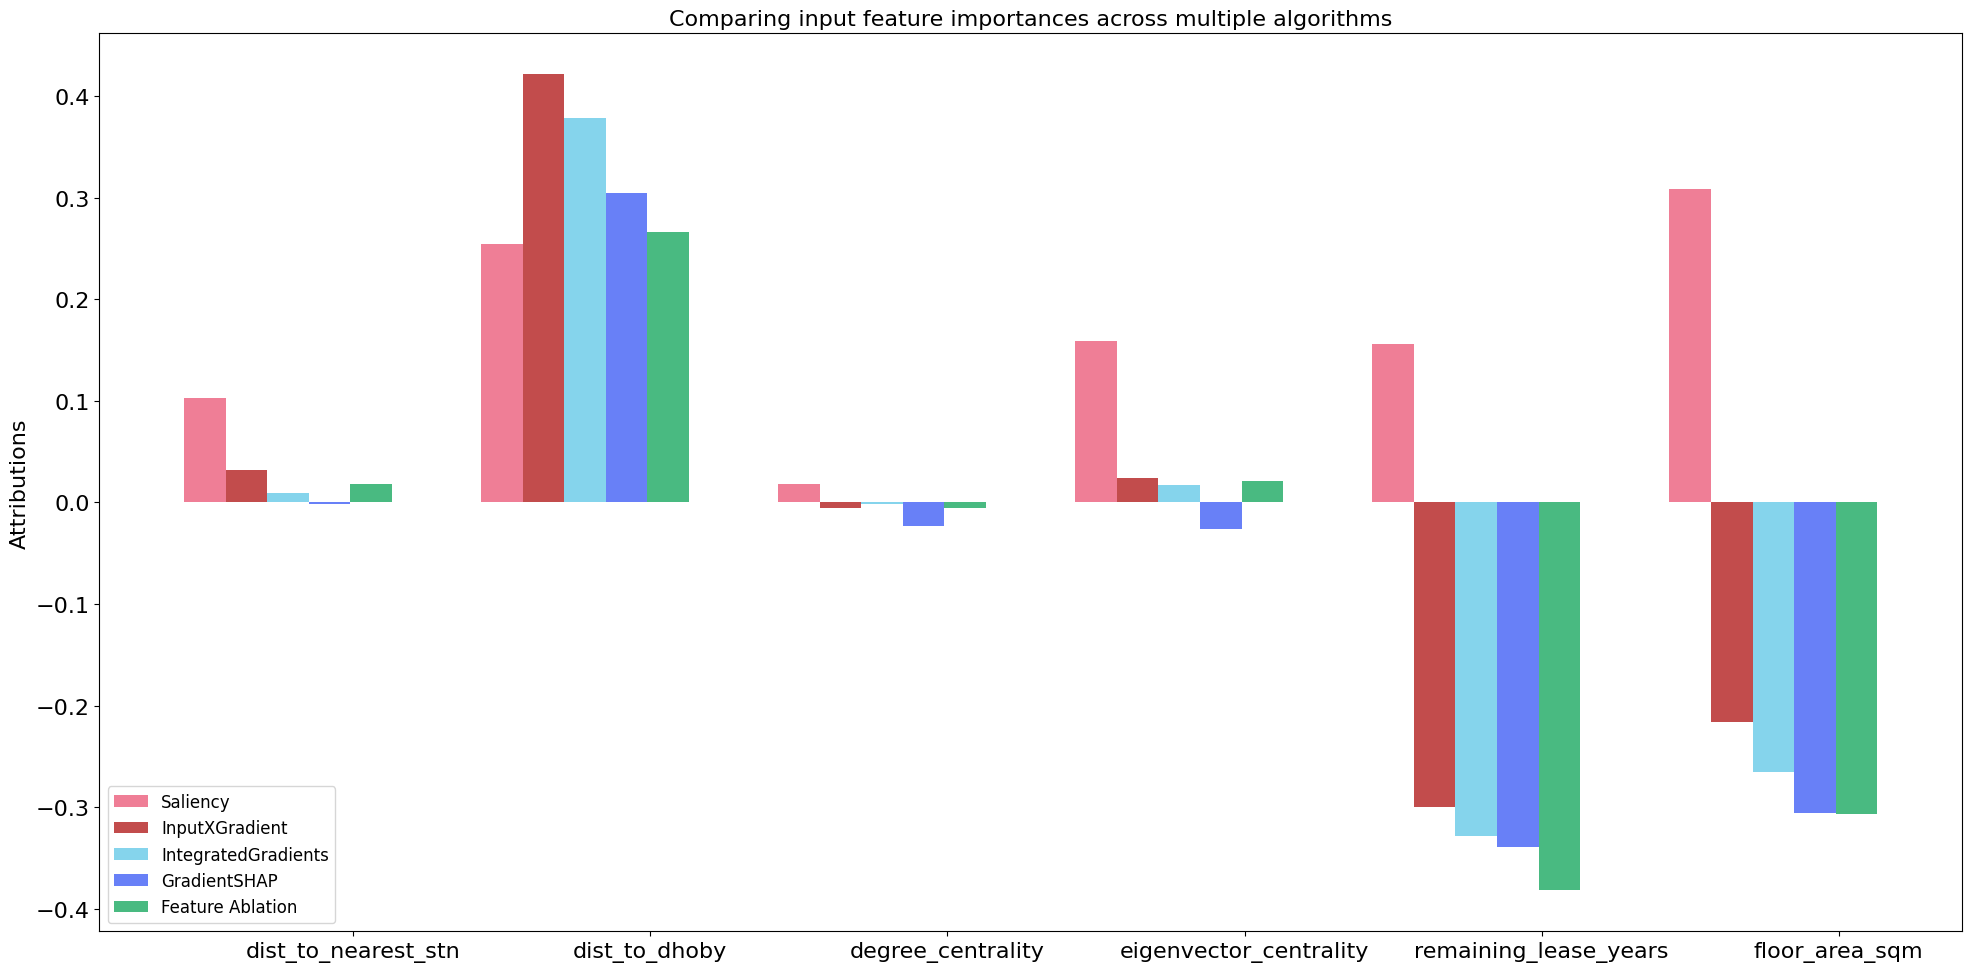

In [10]:
sl = Saliency(model2)
inpg = InputXGradient(model2)
intg = IntegratedGradients(model2)
gs = GradientShap(model2)
fa = FeatureAblation(model2)

sl_attr_test = sl.attribute(first_1000_X_test_scaled_tensor)
inpg_attr_test = inpg.attribute(first_1000_X_test_scaled_tensor)
intg_attr_test = intg.attribute(first_1000_X_test_scaled_tensor)
gs_attr_test = gs.attribute(first_1000_X_test_scaled_tensor, X_train_scaled_tensor)
fa_attr_test = fa.attribute(first_1000_X_test_scaled_tensor)

#prepare attributions for visualization
x_axis_data = np.arange(X_test_tensor.shape[1])

#Saliency
sl_attr_test_sum = sl_attr_test.detach().numpy().sum(0)
sl_attr_test_norm_sum = sl_attr_test_sum / np.linalg.norm(sl_attr_test_sum, ord=1)

#InputXGradient
inpg_attr_test_sum = inpg_attr_test.detach().numpy().sum(0)
inpg_attr_test_norm_sum = inpg_attr_test_sum / np.linalg.norm(inpg_attr_test_sum, ord=1)

#IntegratedGradients
intg_attr_test_sum = intg_attr_test.detach().numpy().sum(0)
intg_attr_test_norm_sum = intg_attr_test_sum / np.linalg.norm(intg_attr_test_sum, ord=1)

#GradientShap
gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

#FeatureAblation
fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)

width = 0.14
legends = ['Saliency', 'InputXGradient','IntegratedGradients', 'GradientSHAP', 'Feature Ablation']

plt.figure(figsize=(20, 10))

ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data, sl_attr_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
ax.bar(x_axis_data + width, inpg_attr_test_norm_sum, width, align='center', alpha=0.7, color='#A90000')
ax.bar(x_axis_data + 2 * width, intg_attr_test_norm_sum, width, align='center', alpha=0.6, color='#34b8e0')
ax.bar(x_axis_data + 3 * width, gs_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
ax.bar(x_axis_data + 4 * width, fa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(["dist_to_nearest_stn",	"dist_to_dhoby", "degree_centrality",	"eigenvector_centrality",	"remaining_lease_years", "floor_area_sqm"])

plt.legend(legends, loc=3)
plt.show()

Answer to the question "state your observations with respect to GradientShap and explain why it has occurred": 

We notice that before scaling feautures, some of GradientShap scores were missing, such as in "degree_centrality" and "eigenvector_centrality". However after scaling features, there now seems to be a score present. This could be because GradientSHAP computes feature attributions based on gradients of the model's output with respect to the input features. If features are on different scales, the gradients will also be on different scales, leading to potentially misleading attributions.

In this case, we might get explanations that reflect the feature values' absolute magnitudes rather than their actual importance in making predictions.

---

Read https://distill.pub/2020/attribution-baselines/ to build up your understanding of Integrated Gradients (IG). Reading the sections before the section on ‘Game Theory and Missingness’ will be sufficient. Keep in mind that this article mainly focuses on classification problems. You might find the following [descriptions](https://captum.ai/docs/attribution_algorithms) and [comparisons](https://captum.ai/docs/algorithms_comparison_matrix) in Captum useful as well.


Then, answer the following questions in the context of our dataset:

> Why did Saliency produce scores similar to IG?


Based on my model, my saliency scores were different from IG (thus i will be answering to my observation)

Integrated Gradients inherently accounts for feature interactions, while Saliency scores may not capture these interactions well since they examine each feature in isolation. Feature interactions can lead to situations where the impact of one feature is canceled out or amplified by the presence of another feature. Integrated Gradients accounts for these interactions by evaluating the cumulative effect of features along the path, allowing for a more accurate representation of feature importance. As such, this could be why they can have different scores.

> Why did Input x Gradients give the same attribution scores as IG?


The choice of baseline in Integrated Gradients could have impacted the results. If the baseline is chosen in such a way that it doesn't introduce significant changes to the input, or if it is very close to the input instance, then Integrated Gradients may produce results that are similar to IG.